<a href="https://colab.research.google.com/github/bandofpv/USNA-Robotics-Courses/blob/main/EW442/Project_6_Comparing_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 6: Comparing Classifiers (Google Colab Edition)

**EW442: Data Science and AI**
**USNA Department of Weapons, Robotics, and Control Engineering**

### **Context & Motivation**

In the civilian sector, financial information is used to produce a credit score—a predictor of the likelihood of a consumer defaulting on a loan.

**Naval Application:** The mathematics of classification you will use here are identical to those used in **Identify Friend or Foe (IFF)** systems, **Electronic Warfare signal classification** (identifying a specific radar emitter from a library), and **Sonar contact analysis** (classifying a return as a mine, a rock, or a submarine).

The first part of this exercise will show you how to use **Python and scikit-learn in Google Colab** to rapidly compare and deploy AI models.

The second part will have you use this workflow on your own to generate a model for a friendly competition hosted on Kaggle. The winner (in each section) of the competition will earn extra credit points.

### **Deliverable**

Submit a written report on how you developed your model. You will want to include a ***discussion*** (I am not just looking for “I did this…”) of your workflow:

* What predictors you experimented with.
* How you split your data between validation and training.
* The various types of models you trained along with the hyperparameters you used.
* A table comparing their performance on the training data.
* A confusion matrix for your leading model.
* Your performance on the test set via the official Kaggle.com site.

### **Set Up**

**Step 0: Kaggle**
Go to: <https://www.kaggle.com/t/35f2cd4218704c69b0dcd814df2f196e>

1. Set up an account (you may have to use a personal email) if needed.
2. Make sure we can recognize your user name to assign you extra credit.
3. **Download the files** `Test.csv` and `Train.csv` to your local computer (e.g., your Downloads folder). You will upload these to Colab in the next step.

### **Part 1: Learning the Workflow in Python**

**Step 1: Import Libraries & Initialize Colab**
Open a new Google Colab notebook. In your first cell, import the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files # Specific for Colab file handling

RANDOM_STATE = 42

**Step 2: Upload and Import Data**
Since Colab runs in the cloud, it does not have access to your local hard drive by default. We must upload the CSV files. Run this cell, and a "Choose Files" button will appear. **Select both `Train.csv` and `Test.csv`.**

In [ ]:
print("Please upload Train.csv and Test.csv now:")
uploaded = files.upload()

# Load the data into pandas
train = pd.read_csv("Train.csv")
test  = pd.read_csv("Test.csv")

# We need to convert Defaulted to categorical/integer
train["Defaulted"] = train["Defaulted"].astype(int)
print("Shape of Train:", train.shape)
print("Shape of Test:", test.shape)

Please upload Train.csv and Test.csv now:


Saving Test.csv to Test (7).csv
Saving Train.csv to Train (7).csv
Shape of Train: (300, 12)
Shape of Test: (100, 11)


**Step 3: Feature Selection & Splitting**

* Make sure your response variable (the thing we want to predict) is “Defaulted”.
* For now, set the percentage of the data to use as a validation set to 10%. Do **not** set aside a test set; the `test` dataframe from Kaggle acts as our blind test set.
* For now, select two *numerical* predictors (Balance and Limit).

In [ ]:
FEATURES = ["Balance", "Limit"]
X = train[FEATURES].copy()
y = train["Defaulted"].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=RANDOM_STATE, stratify=y)

print(f"Train:{len(X_train)}  Val:{len(X_val)}  (10% hold-out)")

Train:270  Val:30  (10% hold-out)


**Step 4: Create Models**
We will quickly create and compare 3 models.

1. Decision Trees / Fine Tree
2. Logistic Regression Classifier / Binary GLM Logistic Regression
3. Nearest Neighbor Classifier / Fine KNN

*Note: Some models do not work with categorical data, which is why we are starting with just two numerical predictors.*

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)  # simple "Fine Tree"-like
clf_log  = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
clf_knn  = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))  # "Fine KNN"-like

models = [("Decision Tree", clf_tree),
   ("Logistic Regression", clf_log),
   ("KNN (k=5)", clf_knn)]

for name, m in models:
    m.fit(X_train, y_train)
    print("Trained:", name)

Trained: Decision Tree
Trained: Logistic Regression
Trained: KNN (k=5)


**Step 5: Parameters**
For each model, print model objects to record key hyperparameters. Make some notes about the various choices for each model.

In [ ]:
for name, m in models:
    print(name, m)

Decision Tree DecisionTreeClassifier(max_depth=5, random_state=42)
Logistic Regression Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, random_state=42))])
KNN (k=5) Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])


**Step 6: Inspect the data**
Create a scatter plot to see how the data is distributed. Note that this is easy for 2 predictors but may be more difficult later in high-dimensional space.

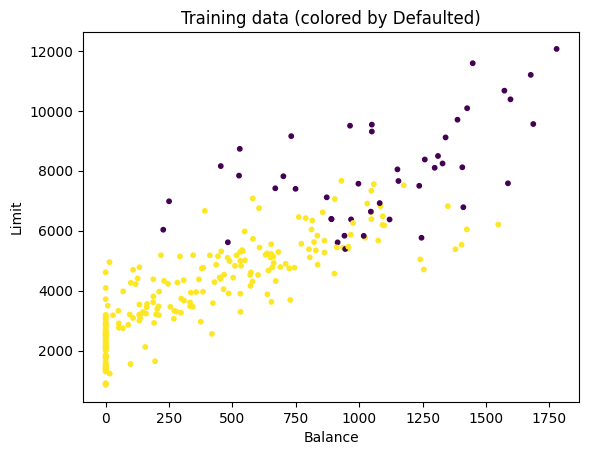

In [ ]:
plt.figure()
plt.scatter(X_train[FEATURES[0]], X_train[FEATURES[1]], c=y_train, s=10, cmap='viridis')
plt.xlabel(FEATURES[0]); plt.ylabel(FEATURES[1])
plt.title("Training data (colored by Defaulted)")
plt.show()

**Step 7: Results**
For each model, compare the evaluation metrics and look at the confusion matrix to determine the best model. We’ll compare validation accuracy in the table below (a better proxy than training accuracy); include this table in your report.

In [ ]:
# --- Step 7A: Compare models (validation accuracy) + show per-model metrics ---
rows = []
for name, m in models:
    y_hat = m.predict(X_val)
    acc = accuracy_score(y_val, y_hat)
    rows.append({"Model": name, "Validation Accuracy": acc})

    # Print richer metrics so YOU can decide "best"
    print(f"\n=== {name} ===")
    print(classification_report(y_val, y_hat, digits=4))

# Compact, sortable comparison (accuracy column)
results_df = (
    pd.DataFrame(rows)
    .sort_values("Validation Accuracy", ascending=False)
    .reset_index(drop=True)
)
print(results_df)


=== Decision Tree ===
              precision    recall  f1-score   support

           0     0.8000    0.8000    0.8000         5
           1     0.9600    0.9600    0.9600        25

    accuracy                         0.9333        30
   macro avg     0.8800    0.8800    0.8800        30
weighted avg     0.9333    0.9333    0.9333        30


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000        25

    accuracy                         1.0000        30
   macro avg     1.0000    1.0000    1.0000        30
weighted avg     1.0000    1.0000    1.0000        30


=== KNN (k=5) ===
              precision    recall  f1-score   support

           0     0.7500    0.6000    0.6667         5
           1     0.9231    0.9600    0.9412        25

    accuracy                         0.9000        30
   macro avg     0.8365    0.7800    0.8039        30
wei

**Step 7B: Decision**
Set `best_name` to the model name you judge as best from the table above (e.g., "Logistic Regression"), then view its confusion matrix.

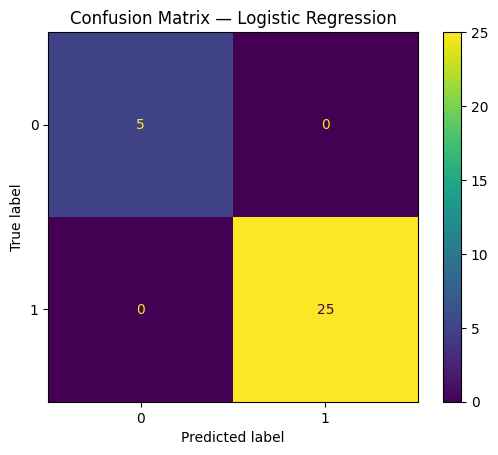

In [ ]:
# --- Step 7B: STUDENT DECISION ---
# Look at 'results_df' (accuracy) AND the printed precision/recall/F1 above.
# Choose the model you judge "best" and assign it here by name:

best_name = "Logistic Regression"   # <-- CHANGE THIS to your choice exactly as shown in 'results_df'
best_model = dict(models)[best_name]

# Confusion matrix for your chosen model
y_val_pred = best_model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

**Step 8: Explainability (Optional)**
Plot the tree structure to discuss splits/interpretability. This is crucial for "Trust" in AI systems.

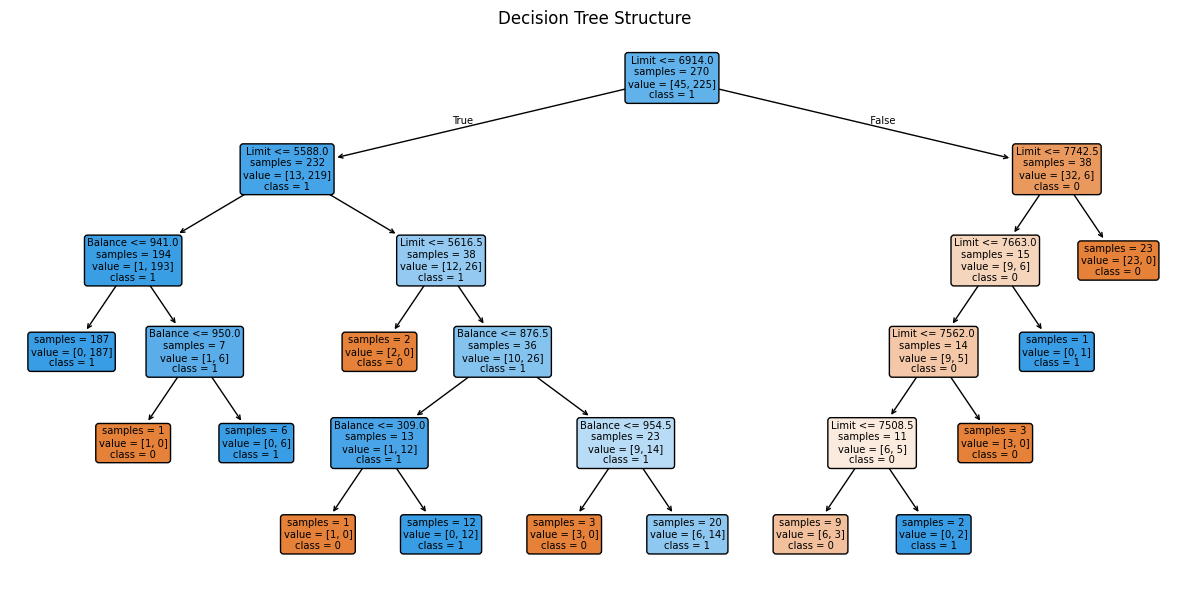

In [ ]:
# --- Step 8: Always show the Decision Tree structure (even if it's not "best") ---
from sklearn.tree import plot_tree

# Ensure the tree is trained on the training split (safe to call fit again)
clf_tree.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
plot_tree(
    clf_tree,
    feature_names=FEATURES,
    class_names=[str(c) for c in np.unique(y_train)],
    filled=True,
    impurity=False,
    rounded=True
)
plt.title("Decision Tree Structure")
plt.tight_layout()
plt.show()

**Step 9: Export and Test**
Select what you think is the best model. To try this model on the test set you will need to make your predictions and then write them to a CSV file.

In Colab, writing the file saves it to the cloud virtual machine. **You must run the `files.download` command to get the file back to your laptop so you can upload it to Kaggle.**

In [ ]:
# Fit best model on ALL training data (not just the split)
best_model.fit(train[FEATURES], train["Defaulted"])
test_preds = best_model.predict(test[FEATURES]).astype(int)

# Create submission dataframe
submission = pd.DataFrame({"Unique_ID": test["Unique_ID"], "Defaulted": test_preds})

# Save to Colab disk
submission.to_csv("Submission.csv", index=False)
print("Wrote Submission.csv to Colab environment.")

# Download to your local machine
files.download('Submission.csv')

Wrote Submission.csv to Colab environment.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Proceed to Part 2. Once complete, you can then manually upload your `Submission.csv` file to Kaggle which will then compute your score for the leaderboard.

### **Part 2: Model Selection (The Competition)**

Now that you have seen the workflow, you can try to develop the best possible model.

**Options to experiment with:**

* **Feature Engineering:** Which inputs/predictors to use? (Tip: not every classification algorithm supports categorical variables; also it never makes sense to use the `Unique_ID` column as an input).

* **Validation Split:** What percent of the data point to hold out for validation?

* **Algorithms:** Which type of classification algorithm (e.g. Decision Tree vs Support Vector Machine vs Neural Nets)?

* **Hyperparameters:** What values of the hyperparameters to use (e.g. number of tree splits, K value, number of neurons, etc.).

**Handling Categorical Inputs (One-Hot Encoding)**
If you want to use categorical variables (like "Married" or "Education"), you must encode them. Here is a snippet to help you do that in your workflow:

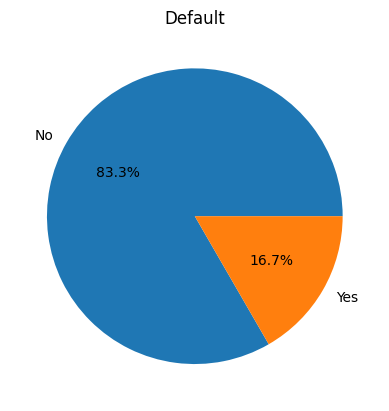

In [ ]:
# Select all features for data visualization
FEATURES = ["Limit", "Cards", "Age", "Education", "Own", "Student", "Married", "Region", "Balance"]

X = train[FEATURES].copy()
y = train["Defaulted"].copy()

# One-hot encode the categorical column ("Married") for train/val
categorical_cols = ["Own", "Student", "Married", "Region"]
X_enc = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Visualize default distribution
plt.pie(y.value_counts(), labels=["No", "Yes"], autopct='%1.1f%%')
plt.title("Default")
plt.show()

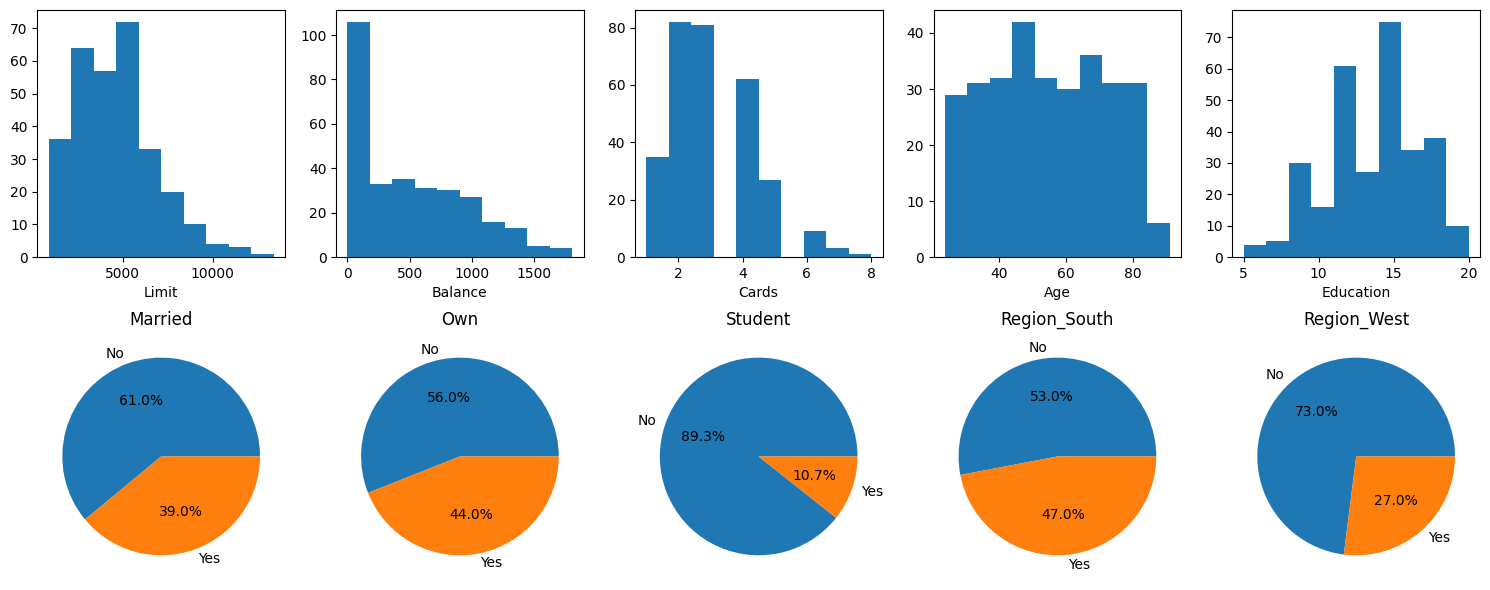

In [ ]:
# Visualize all features
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

axes[0].hist(X_enc["Limit"])
axes[0].set_xlabel("Limit")

axes[1].hist(X_enc["Balance"])
axes[1].set_xlabel("Balance")

axes[2].hist(X_enc["Cards"])
axes[2].set_xlabel("Cards")

axes[3].hist(X_enc["Age"])
axes[3].set_xlabel("Age")

axes[4].hist(X_enc["Education"])
axes[4].set_xlabel("Education")

axes[5].pie(X_enc["Married_Yes"].value_counts(), labels=["No", "Yes"], autopct='%1.1f%%')
axes[5].set_title("Married")

axes[6].pie(X_enc["Own_Yes"].value_counts(), labels=["No", "Yes"], autopct='%1.1f%%')
axes[6].set_title("Own")

axes[7].pie(X_enc["Student_Yes"].value_counts(), labels=["No", "Yes"], autopct='%1.1f%%')
axes[7].set_title("Student")

axes[8].pie(X_enc["Region_South"].value_counts(), labels=["No", "Yes"], autopct='%1.1f%%')
axes[8].set_title("Region_South")

axes[9].pie(X_enc["Region_West"].value_counts(), labels=["No", "Yes"], autopct='%1.1f%%')
axes[9].set_title("Region_West")

plt.tight_layout()
plt.show()

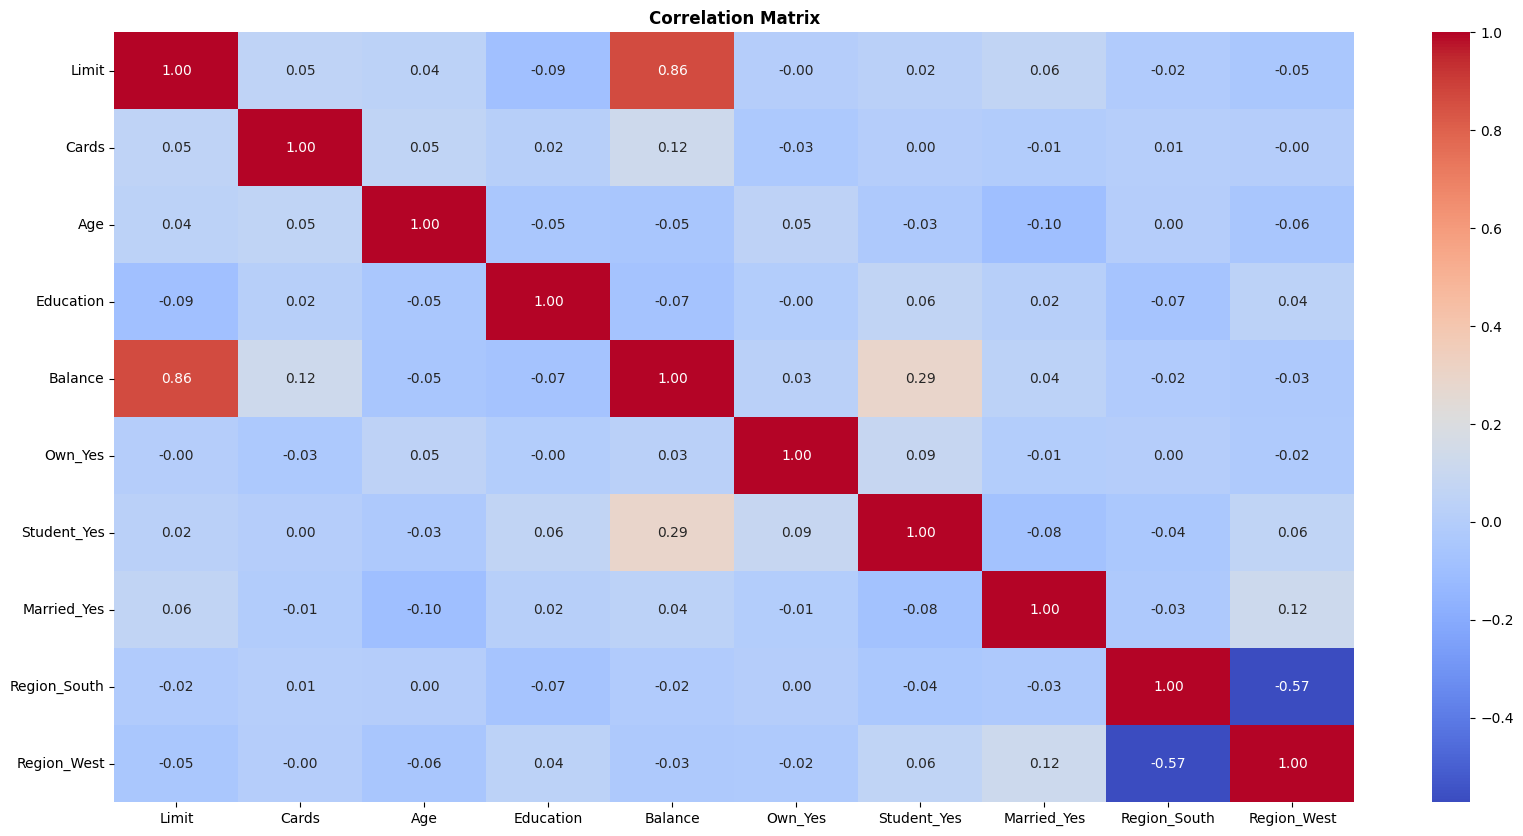

In [ ]:
# Visualize correlation matrix
heatmap = X_enc.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(data=heatmap, fmt=".2f", annot=True, cmap="coolwarm")
plt.title("Correlation Matrix", fontweight="bold")
plt.show()

In [ ]:
# Remove balance feature
FEATURES = ["Limit", "Cards", "Age", "Education", "Own", "Student", "Married", "Region"]

X = train[FEATURES].copy()
y = train["Defaulted"].copy()

# 60/40 traint/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)

print(f"Train:{len(X_train)}  Val:{len(X_val)}  (40% hold-out)")

# One-hot encode the categorical column ("Married") for train/val
categorical_cols = ["Own", "Student", "Married", "Region"]
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val_enc   = pd.get_dummies(X_val,   columns=categorical_cols, drop_first=True)

# Align validation columns to training columns (handle any missing dummy columns)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

Train:180  Val:120  (40% hold-out)


In [ ]:
# Fit Decision Tree, Logistic Regression, KNN, and Random Forest Models
clf_tree = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
clf_log  = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
clf_knn  = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
clf_rf = RandomForestClassifier(random_state=RANDOM_STATE)

models = [("Decision Tree", clf_tree),
    ("Logistic Regression", clf_log),
    ("KNN (k=5)", clf_knn),
    ("Random Forest", clf_rf)]

for name, m in models:
    m.fit(X_train_enc, y_train)
    print("Trained:", name)

Trained: Decision Tree
Trained: Logistic Regression
Trained: KNN (k=5)
Trained: Random Forest


In [ ]:
# Compare models (validation accuracy) + show per-model metrics
rows = []
for name, m in models:
    y_hat = m.predict(X_val_enc)
    acc = accuracy_score(y_val, y_hat)
    rows.append({"Model": name, "Validation Accuracy": acc})

    # Print richer metrics so YOU can decide "best"
    print(f"\n=== {name} ===")
    print(classification_report(y_val, y_hat, digits=4))

# Compact, sortable comparison (accuracy column)
results_df = (
    pd.DataFrame(rows)
    .sort_values("Validation Accuracy", ascending=False)
    .reset_index(drop=True)
)
print(results_df)


=== Decision Tree ===
              precision    recall  f1-score   support

           0     0.6400    0.8000    0.7111        20
           1     0.9579    0.9100    0.9333       100

    accuracy                         0.8917       120
   macro avg     0.7989    0.8550    0.8222       120
weighted avg     0.9049    0.8917    0.8963       120


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.6250    0.7500    0.6818        20
           1     0.9479    0.9100    0.9286       100

    accuracy                         0.8833       120
   macro avg     0.7865    0.8300    0.8052       120
weighted avg     0.8941    0.8833    0.8874       120


=== KNN (k=5) ===
              precision    recall  f1-score   support

           0     0.6667    0.2000    0.3077        20
           1     0.8596    0.9800    0.9159       100

    accuracy                         0.8500       120
   macro avg     0.7632    0.5900    0.6118       120
wei

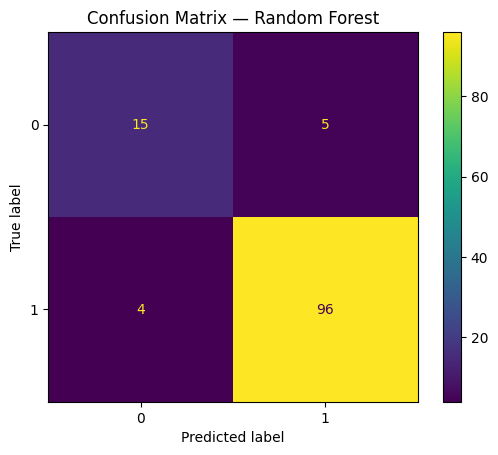

In [ ]:
# Select best model
best_name = "Random Forest"
best_model = dict(models)[best_name]

# Confusion matrix for your chosen model
y_val_pred = best_model.predict(X_val_enc)
cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

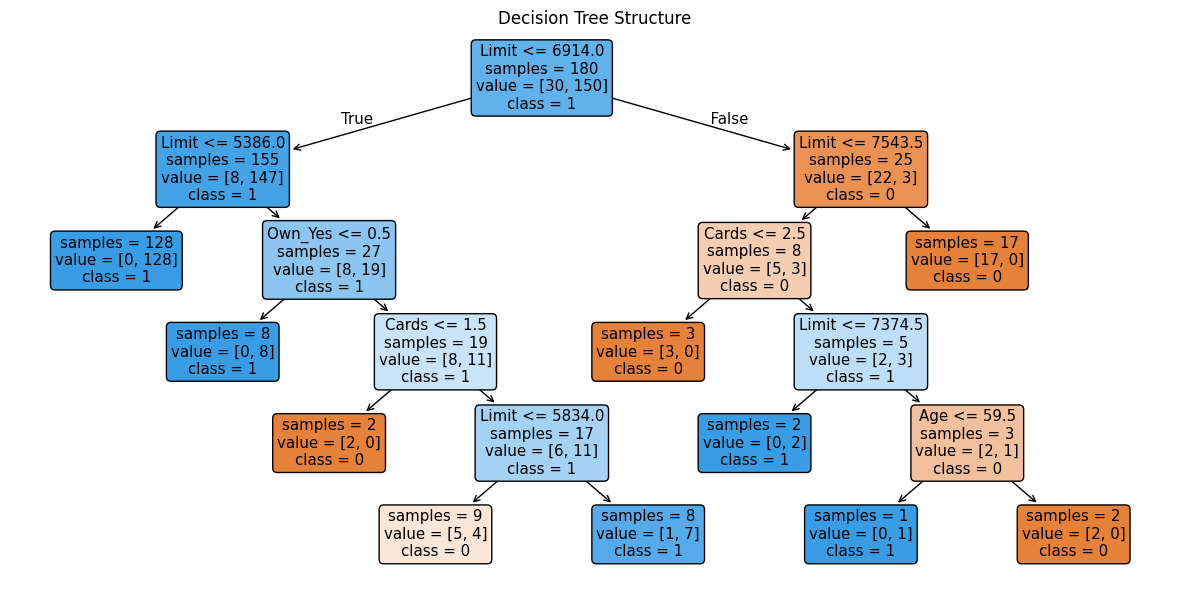

In [ ]:
# Plot Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(
    clf_tree,
    feature_names=X_train_enc.columns,
    class_names=[str(c) for c in np.unique(y_train)],
    filled=True,
    impurity=False,
    rounded=True
)
plt.title("Decision Tree Structure")
plt.tight_layout()
plt.show()

In [ ]:
# Train best model on all data
X_all = train[FEATURES].copy()
X_test = test[FEATURES].copy()

# One-hot encode the categorical column ("Married") for train/val
X_all_enc = pd.get_dummies(X_all, columns=categorical_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Reindex to match X_all_enc columns
X_test_enc = X_test_enc.reindex(columns=X_test_enc.columns, fill_value=0)

# Fit best model on ALL training data (not just the split)
best_model.fit(X_all_enc, train["Defaulted"])
test_preds = best_model.predict(X_test_enc).astype(int)

# Create submission dataframe
submission = pd.DataFrame({"Unique_ID": test["Unique_ID"], "Defaulted": test_preds})

# Save to Colab disk
submission.to_csv("Submission.csv", index=False)
print("Wrote Submission.csv to Colab environment.")

# Download to your local machine
files.download('Submission.csv')

Wrote Submission.csv to Colab environment.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

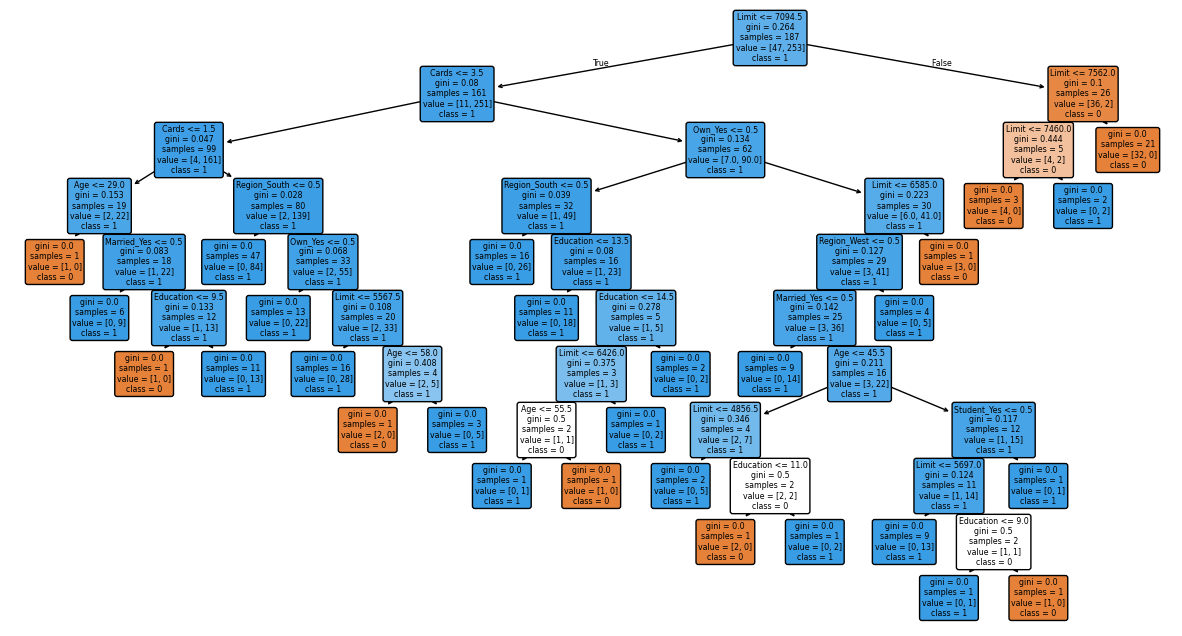

In [ ]:
# Plot Random Forest
plt.figure(figsize=(15, 8))
plot_tree(best_model.estimators_[0],
          feature_names=X_train_enc.columns,
          class_names=[str(c) for c in np.unique(y_train)],
          filled=True,
          rounded=True)
plt.show()